In [12]:
import os 
import sys
import time
import glob
import pickle
import itertools
import logging
import pyprind
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import fbeta_score, accuracy_score, roc_curve, auc
from sklearn.utils import shuffle

import utils
import data_prep as prep
import train_select as ts

In [2]:
random_state = 42
batch_dir = "dataset/batches"
val_ratio = .15
batch_size = 256
n_epochs = 50
validate_every = 50
print_every = batch_size * 2

In [3]:
npi = prep.prepare_npi(prep.npi_url)

naive = [True] * len(npi)
naive_acc = accuracy_score(naive, npi['op_longer'])
naive_f = fbeta_score(naive, npi['op_longer'], beta=.5)
print('')
print("=========== Benchmark score =========== ")
print("Accuracy score: {:.4f}".format(naive_acc))
print("F score: {:.4f}".format(naive_f))

INFO Data set PartD_Prescriber_PUF_NPI_15.zip
INFO from url: http://download.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Downloads/PartD_Prescriber_PUF_NPI_15.zip
INFO successfully downloaded and uncompressed
INFO Data cleaning completed
INFO New features are added

=========== Benchmark score =========== 
Accuracy score: 0.1537
F score: 0.4759


We will compare five candidate classification models that support partial fit - linear support vector machine, logistic regression, perceptron, passive aggressive classifier, and Naive Bayes multinormial classifier. 

In [4]:
partial_fit_classifiers = {
    'SGD-SVM': SGDClassifier(random_state=random_state, loss='hinge'),
    'SGD-Log': SGDClassifier(random_state=random_state, loss='log'),
    'Perceptron': Perceptron(random_state=random_state),
    'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier(random_state=random_state)
}

# Split datasets 

In [5]:
train_batch_names, test_batch_names, val_batch_names = ts.get_batchnames(split_val=True)

number of train batches: 60
Number of validation batches: 10
number of test batches: 12


In [6]:
val_features, val_labels = ts.concat_batches(val_batch_names)

INFO Concatenating 10 batches


0% [##########] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04




# Train on the training batches

In [7]:
def initialize_stats(partial_fit_classifiers):
    results = {}
    for clf_name in partial_fit_classifiers:
        stats = {
            'n_train': [],
            'train_time': [],
            'pred_time': [],
            'acc_train': [],
            'acc_test': [],
            'f_train': [],
            'f_test': []
        }
        results[ clf_name ] = stats
    return results

In [8]:
def train_predict(partial_fit_classifiers, train_batch_names, val_features, val_labels):
    classes = np.array([ 0, 1 ])
    results = initialize_stats(partial_fit_classifiers)
    steps = 0

    for batch_i in range(len(train_batch_names)):
        for X_train, y_train in ts.load_train_batches(train_batch_names, batch_i, batch_size):
            for clf_name, clf in partial_fit_classifiers.items():
                steps += 1
                # train via partial fit
                tick = time.time()
                clf.partial_fit(X_train, y_train, classes=classes)
                train_time = time.time() - tick

                # predict
                tick = time.time()
                pred_train = clf.predict(X_train)
                pred_time = time.time() - tick

                pred_train = clf.predict(X_train)
                results[ clf_name ][ 'train_time' ].append(train_time)
                results[ clf_name ][ 'pred_time' ].append(pred_time)
                results[ clf_name ][ 'n_train' ].append(X_train.shape[ 0 ])
                results[ clf_name ][ 'acc_train' ].append(accuracy_score(y_train, pred_train))
                results[ clf_name ][ 'f_train' ].append(fbeta_score(y_train, pred_train, beta=.5))

        X_val, y_val = ts.load_random_test_batch(val_features, val_labels, batch_size)
        for clf_name, clf in partial_fit_classifiers.items():
            pred_val = clf.predict(X_val)
            results[ clf_name ][ 'acc_test' ].append(accuracy_score(y_val, pred_val))
            results[ clf_name ][ 'f_test' ].append(fbeta_score(y_val, pred_val, beta=.5))
            

        logging.info(
            "batch {} / {} ================================".format(batch_i + 1, len(train_batch_names)))
        # logging.info("Number of validation sample: {}".format(X_train.shape[ 0 ]))
        logging.info("F-beta score (beta=0.5) on training set:")
        logging.info("SGD-SVM: {}".format(results[ 'SGD-SVM' ][ 'f_train' ][ -1 ]))
        logging.info("SGD-Log: {}".format(results[ 'SGD-Log' ][ 'f_train' ][ -1 ]))
        logging.info("Perceptron: {}".format(results[ 'Perceptron' ][ 'f_train' ][ -1 ]))
        logging.info("NB Multinomial: {}".format(results[ 'NB Multinomial' ][ 'f_train' ][ -1 ]))
        logging.info("PA: {}".format(results[ 'Passive-Aggressive' ][ 'f_train' ][ -1 ]))
        # logging.info("==========================================")

    return results

In [9]:
results = train_predict(partial_fit_classifiers, train_batch_names, val_features, val_labels) 

INFO batch 1 / 60 ================================
INFO F-beta score (beta=0.5) on training set:
INFO SGD-SVM: 0.6440677966101696
INFO SGD-Log: 0.6109324758842443
INFO Perceptron: 0.5752212389380531
INFO NB Multinomial: 0.6477732793522267
INFO PA: 0.6507936507936508
INFO batch 2 / 60 ================================
INFO F-beta score (beta=0.5) on training set:
INFO SGD-SVM: 0.7333333333333333
INFO SGD-Log: 0.7142857142857142
INFO Perceptron: 0.7971014492753623
INFO NB Multinomial: 0.7272727272727274
INFO PA: 0.7333333333333333
INFO batch 3 / 60 ================================
INFO F-beta score (beta=0.5) on training set:
INFO SGD-SVM: 0.743801652892562
INFO SGD-Log: 0.7092198581560284
INFO Perceptron: 0.7560975609756098
INFO NB Multinomial: 0.5809128630705395
INFO PA: 0.7182320441988951
INFO batch 4 / 60 ================================
INFO F-beta score (beta=0.5) on training set:
INFO SGD-SVM: 0.6493506493506493
INFO SGD-Log: 0.6741573033707865
INFO Perceptron: 0.7664233576642336
I

INFO SGD-SVM: 0.8620689655172415
INFO SGD-Log: 0.8064516129032259
INFO Perceptron: 0.8333333333333334
INFO NB Multinomial: 0.7407407407407408
INFO PA: 0.8823529411764706
INFO batch 34 / 60 ================================
INFO F-beta score (beta=0.5) on training set:
INFO SGD-SVM: 0.6701030927835052
INFO SGD-Log: 0.7303370786516854
INFO Perceptron: 0.8235294117647058
INFO NB Multinomial: 0.4744525547445256
INFO PA: 0.7522123893805309
INFO batch 35 / 60 ================================
INFO F-beta score (beta=0.5) on training set:
INFO SGD-SVM: 0.8021390374331551
INFO SGD-Log: 0.8064516129032256
INFO Perceptron: 0.8285714285714286
INFO NB Multinomial: 0.5893536121673005
INFO PA: 0.8187134502923976
INFO batch 36 / 60 ================================
INFO F-beta score (beta=0.5) on training set:
INFO SGD-SVM: 0.7000000000000001
INFO SGD-Log: 0.6451612903225806
INFO Perceptron: 0.47619047619047616
INFO NB Multinomial: 0.48245614035087725
INFO PA: 0.5384615384615385
INFO batch 37 / 60 =====

# Plot results

### 1. Run time

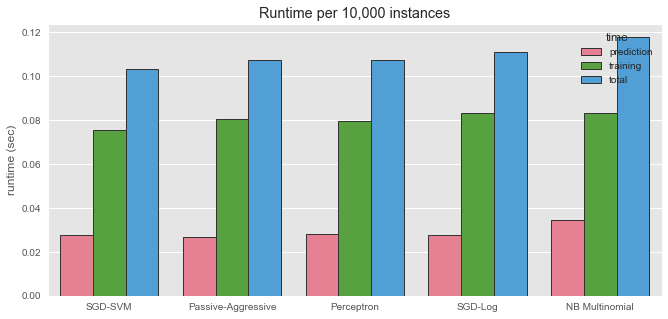

In [13]:
time_res = ts.get_time_res(results)
ts.plot_time(time_res)

 

## 2. Accuracy and F-beta score

In [11]:
def plot_score(results, window=20):
    my_col = sns.color_palette("husl", 5)
    plt.figure(figsize=(12, 6))
    ax1 = plt.subplot(121)

    for i, clf_name in enumerate(partial_fit_classifiers.keys()):
        plt.plot(pd.Series(results[ clf_name ][ 'acc_train' ]).rolling(window=window).mean(),
                 color=my_col[ i ], linewidth=2)
    plt.ylabel("Accuracy")
    plt.xlabel("Training steps")
    plt.legend(loc="best", labels=partial_fit_classifiers.keys())
    plt.title("Accuracy on training set")

    ax2 = plt.subplot(122, sharey=ax1)
    for i, clf_name in enumerate(partial_fit_classifiers.keys()):
        plt.plot(pd.Series(results[ clf_name ][ 'f_train' ]).rolling(window=window).mean(),
                 color=my_col[ i ], linewidth=2)
    plt.ylabel("F-score")
    plt.xlabel("Training steps")
    # plt.legend(loc="best", labels=partial_fit_classifiers.keys())
    plt.title("F score (beta=0.5) on training set")
    plt.savefig("assets/compare_score.png")
    plt.show()
    
#plot_score(results, window=150)

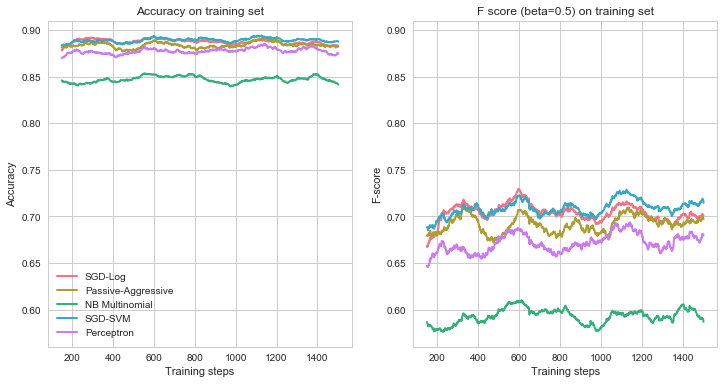

In [33]:
plot_score(results, window=150)

In [13]:
mean_scores, acc_test, f_test = ts.get_test_score(results)
mean_scores

,acc_test_mean,f_test_mean
SGD-Log,0.869271,0.642768
SGD-SVM,0.858398,0.612183
NB Multinomial,0.839518,0.560809
Perceptron,0.831120,0.536410
Passive-Aggressive,0.831706,0.535115


In [14]:
# INFO Avg test scores:                     acc_test_mean  f_test_mean
# SGD-Log                  0.869271     0.642768
# SGD-SVM                  0.858398     0.612183
# NB Multinomial           0.839518     0.560809
# Perceptron               0.831120     0.536410
# Passive-Aggressive       0.831706     0.535115

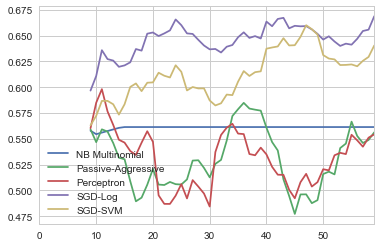

In [34]:
pd.rolling_mean(f_test, 10).plot()

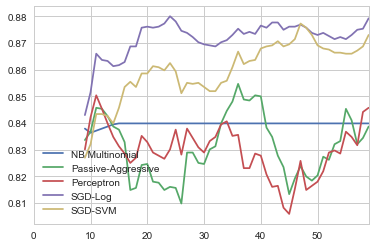

In [35]:
pd.rolling_mean(acc_test, 10).plot()

# Hyperparameter tuning via grid search

As GridSearchCV in scikit-learn doesn't support algorithms with partial fit, let's manually search the hyperparameter space. 

In [17]:
loss = ['log', 'hinge']
alpha = [.000001, .00001, .0001, .001]
l1_ratio = [0., .1, .2, .3, .4, .5, .6, .7, .8, .9]

In [18]:
search_res = ts.sgd_grid_search(train_batch_names, val_features, val_labels, loss, alpha, l1_ratio, random_state)


INFO 1/80 Evaluating hyperparameters: 
INFO loss: log, alpha: 1e-06, l1_ratio: 0.0
INFO Validation F-score: 0.5154639175257733

INFO 2/80 Evaluating hyperparameters: 
INFO loss: log, alpha: 1e-06, l1_ratio: 0.1
INFO Validation F-score: 0.6050955414012741

INFO 3/80 Evaluating hyperparameters: 
INFO loss: log, alpha: 1e-06, l1_ratio: 0.2
INFO Validation F-score: 0.5263157894736842

INFO 4/80 Evaluating hyperparameters: 
INFO loss: log, alpha: 1e-06, l1_ratio: 0.3
INFO Validation F-score: 0.6201550387596899

INFO 5/80 Evaluating hyperparameters: 
INFO loss: log, alpha: 1e-06, l1_ratio: 0.4
INFO Validation F-score: 0.6687898089171972

INFO 6/80 Evaluating hyperparameters: 
INFO loss: log, alpha: 1e-06, l1_ratio: 0.5
INFO Validation F-score: 0.4887218045112781

INFO 7/80 Evaluating hyperparameters: 
INFO loss: log, alpha: 1e-06, l1_ratio: 0.6
INFO Validation F-score: 0.4705882352941177

INFO 8/80 Evaluating hyperparameters: 
INFO loss: log, alpha: 1e-06, l1_ratio: 0.7
INFO Validation F-sc

INFO loss: hinge, alpha: 0.0001, l1_ratio: 0.3
INFO Validation F-score: 0.6194690265486724

INFO 65/80 Evaluating hyperparameters: 
INFO loss: hinge, alpha: 0.0001, l1_ratio: 0.4
INFO Validation F-score: 0.6201550387596899

INFO 66/80 Evaluating hyperparameters: 
INFO loss: hinge, alpha: 0.0001, l1_ratio: 0.5
INFO Validation F-score: 0.6637168141592921

INFO 67/80 Evaluating hyperparameters: 
INFO loss: hinge, alpha: 0.0001, l1_ratio: 0.6
INFO Validation F-score: 0.6410256410256411

INFO 68/80 Evaluating hyperparameters: 
INFO loss: hinge, alpha: 0.0001, l1_ratio: 0.7
INFO Validation F-score: 0.6666666666666665

INFO 69/80 Evaluating hyperparameters: 
INFO loss: hinge, alpha: 0.0001, l1_ratio: 0.8
INFO Validation F-score: 0.7079646017699114

INFO 70/80 Evaluating hyperparameters: 
INFO loss: hinge, alpha: 0.0001, l1_ratio: 0.9
INFO Validation F-score: 0.6410256410256411

INFO 71/80 Evaluating hyperparameters: 
INFO loss: hinge, alpha: 0.001, l1_ratio: 0.0
INFO Validation F-score: 0.668

In [19]:
search_res = search_res.sort_values(by='val_f_score', ascending=False)
search_res.iloc[:10, :]

,alpha,l1_ratio,loss,val_f_score
29,0.0001,0.9,log,0.714286
28,0.0001,0.8,log,0.714286
68,0.0001,0.8,hinge,0.707965
20,0.0001,0.0,log,0.697674
22,0.0001,0.2,log,0.697674
21,0.0001,0.1,log,0.697674
38,0.0010,0.8,log,0.696970
37,0.0010,0.7,log,0.696970
36,0.0010,0.6,log,0.696970
35,0.0010,0.5,log,0.696970


In [20]:
best_param = search_res.iloc[0]
best_param

alpha            0.0001
l1_ratio            0.9
loss                log
val_f_score    0.714286
Name: 29, dtype: object

In [21]:
train_batch_names, test_batch_names = ts.get_batchnames(split_val=False)

number of train batches: 70
number of test batches: 12


In [22]:
test_features, test_labels = ts.concat_batches(test_batch_names)

INFO Concatenating 12 batches


0% [############] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


In [23]:
best_clf = SGDClassifier(loss=best_param['loss'], 
                         alpha=best_param['alpha'], 
                         l1_ratio=best_param['l1_ratio'], 
                         random_state=random_state,
                         average=True)
classes = np.array([0, 1])

pbar = pyprind.ProgBar(len(train_batch_names))
for batch_i in range(len(train_batch_names)):
    for X_train, y_train in ts.load_train_batches(train_batch_names, batch_i, batch_size):
        best_clf.partial_fit(X_train, y_train, classes=classes) 
    pbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:26


In [24]:
final_f_score, final_accuracy = ts.eval_error(best_clf, test_features, test_labels)
final_f_score, final_accuracy

(0.73619631901840488, 0.9140625)

In [25]:
# INFO grid seach result is saved as: results/grid_search_res.pickle
# INFO Best parameters selected: alpha            0.0001
# l1_ratio            0.8
# loss                log
# val_f_score    0.714286
# Name: 68, dtype: object
# number of train batches: 70
# number of test batches: 12
# 0% [##############################] 100% | ETA: 00:00:00
# Total time elapsed: 00:00:11
# INFO Test F-score: 0.7361963190184049
# INFO Test accuracy: 0.9140625
# INFO Best model is saved as results/best_model.pickle

Let's save the fine-tuned model

In [26]:
with open('results/best_model.pickle', 'wb') as f:
    pickle.dump(best_clf, f)

# Inference

In [27]:
import pandas as pd 
import numpy as np
import pickle

with open('results/best_model.pickle', 'rb') as f:
    best_clf = pickle.load(f)

In [28]:
n_features = 535
probs = []
for i in range(n_features):
    tmp = np.zeros((1, n_features))
    tmp[0, i] = 1
    probs.append(best_clf.predict_proba(tmp)[0][1])

In [29]:

prob_table = pd.DataFrame(probs, columns = ['prob'])
prob_table['feat'] = test_features.columns


In [30]:
prob_table.sort_values(by='prob', ascending=False)[:50]

,prob,feat
77,0.883438,specialty_anesthesiology
113,0.881784,specialty_interventional_pain_management
89,0.869178,specialty_rheumatology
82,0.867659,specialty_pain_management
184,0.862213,carisoprodol
83,0.846161,specialty_infectious_disease
88,0.838012,specialty_hematology_oncology
315,0.837919,hydroxychloroquine_sulfate
58,0.830444,specialty_physical_medicine_and_rehabilitation
100,0.795607,specialty_medical_oncology
